# Gravitational astrophysics: resonances among the Saturnian satellites

## 1. Introduction

In [23]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

sim = rebound.Simulation()
sim.units = ('AU', 'days', 'Msun')

# We can add Jupiter and four of its moons by name, since REBOUND is linked to the HORIZONS database.
labels = ["699","Mimas","Tethys","Titan", "Enceladus", "Dione", "Rhea"]
sim.add(labels)

Searching NASA Horizons for '699'... 
Found: Saturn (699) 
Searching NASA Horizons for 'Mimas'... 
Found: Mimas (601) 
Searching NASA Horizons for 'Tethys'... 
Found: Tethys (603) 
Searching NASA Horizons for 'Titan'... 
Found: Titan (606) (chosen from query 'Titan')
Searching NASA Horizons for 'Enceladus'... 
Found: Enceladus (602) 
Searching NASA Horizons for 'Dione'... 
Found: Dione (604) 
Searching NASA Horizons for 'Rhea'... 
Found: Rhea (605) 


In [24]:
os = sim.orbits()
print("n_i (in rad/days) = %6.3f, %6.3f, %6.3f" % (os[0].n,os[1].n,os[2].n))
print("P_i (in days)     = %6.3f, %6.3f, %6.3f" % (os[0].P,os[1].P,os[2].P))

n_i (in rad/days) =  6.633,  3.322,  0.394
P_i (in days)     =  0.947,  1.892, 15.948


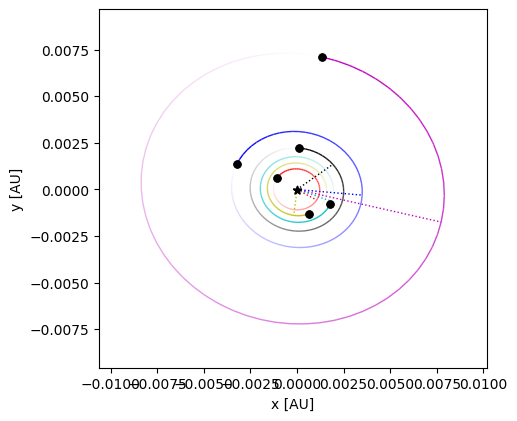

In [25]:
sim.move_to_com()
op = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True)

In [26]:
sim.integrator = "whfast"
sim.dt = 0.05 * os[0].P  # 5% of Io's period
Nout = 100_000            # number of points to display
tmax = 80*365.25         # let the simulation run for 80 years
Nmoons = 6

In [27]:
x = np.zeros((Nmoons,Nout))
ecc = np.zeros((Nmoons,Nout))
longitude = np.zeros((Nmoons,Nout))
Omega = np.zeros((Nmoons,Nout))
n = np.zeros((Nmoons,Nout))
pos = np.zeros(shape=(len(labels),3,Nout))
vit = np.zeros(shape=(len(labels),3,Nout))

times = np.linspace(0.,tmax,Nout)
ps = sim.particles

def ForceJ2(reb_sim):
    J2 = 16298e-6
    RSat = 0.00038925688 #AU
    MSat = 0.00028588598 #Msun
    for sat in range(1,Nmoons+1):
        prx = ps[sat].x-ps[0].x
        pry = ps[sat].y-ps[0].y
        prz = ps[sat].z-ps[0].z
        pr2 = prx*prx + pry*pry + prz*prz
        fac = -3*sim.G*J2*MSat*(RSat**2)/2/(pr2**(3.5))
        
        
        
        pax = fac*prx*(prx*prx + pry*pry - 4*prz*prz)
        pay = fac*pry*(prx*prx + pry*pry - 4*prz*prz)
        paz = fac*prz*(3*(prx*prx + pry*pry) - 2*prz*prz)

        ps[sat].ax += pax
        ps[sat].ay += pay
        ps[sat].az += paz

        mfac = ps[sat].m/ps[0].m

        ps[0].ax -= mfac*pax
        ps[0].ay -= mfac*pay
        ps[0].az -= mfac*paz

sim.additional_forces = ForceJ2

for i,time in enumerate(times):
    sim.integrate(time)
    # note we use integrate() with the default exact_finish_time=1, which changes the timestep near 
    # the outputs to match the output times we want.  This is what we want for a Fourier spectrum, 
    # but technically breaks WHFast's symplectic nature.  Not a big deal here.
    os = sim.orbits()
    for k,body in enumerate(ps):
        pos[k,0,i] = ps[k].x
        pos[k,1,i] = ps[k].y
        pos[k,2,i] = ps[k].z

        vit[k,0,i] = ps[k].vx
        vit[k,1,i] = ps[k].vy
        vit[k,2,i] = ps[k].vz

    for j in range(Nmoons):
        x[j][i] = ps[j+1].x 
        ecc[j][i] = os[j].e
        longitude[j][i] = os[j].l
        Omega[j][i] = os[j].Omega
        n[j][i] = os[j].n

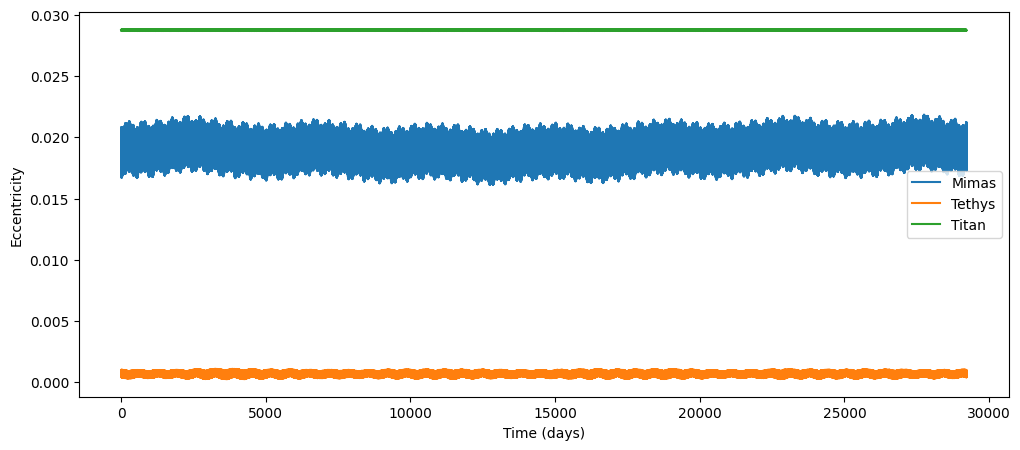

In [28]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,ecc[0],label=labels[1])
plt.plot(times,ecc[1],label=labels[2])
plt.plot(times,ecc[2],label=labels[3])
# plt.plot(times,ecc[3],label=labels[4])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Eccentricity")
plt.legend()

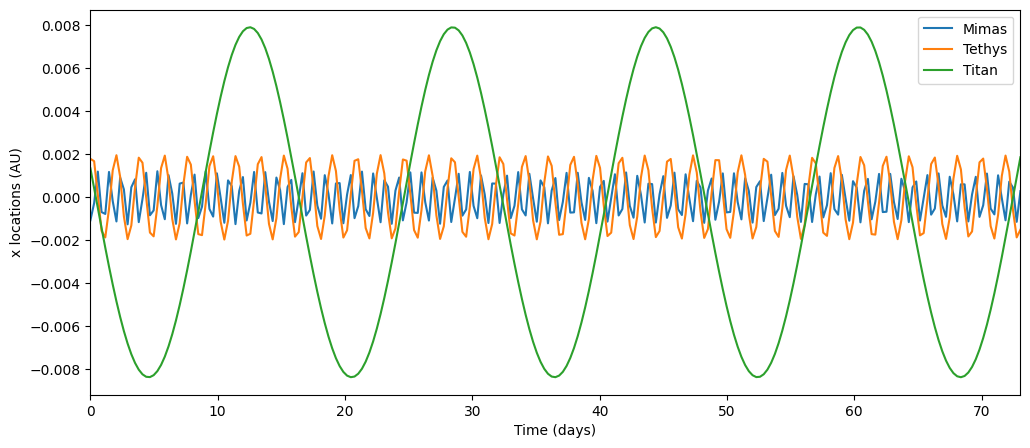

In [29]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
plt.plot(times,x[0],label=labels[1])
plt.plot(times,x[1],label=labels[2])
plt.plot(times,x[2],label=labels[3])
# plt.plot(times,x[3],label=labels[4])
ax.set_xlim(0,0.2*365.25)
ax.set_xlabel("Time (days)")
ax.set_ylabel("x locations (AU)")
ax.tick_params()
plt.legend()

Text(0, 0.5, 'resonant argument $Mimas-Thetys$')

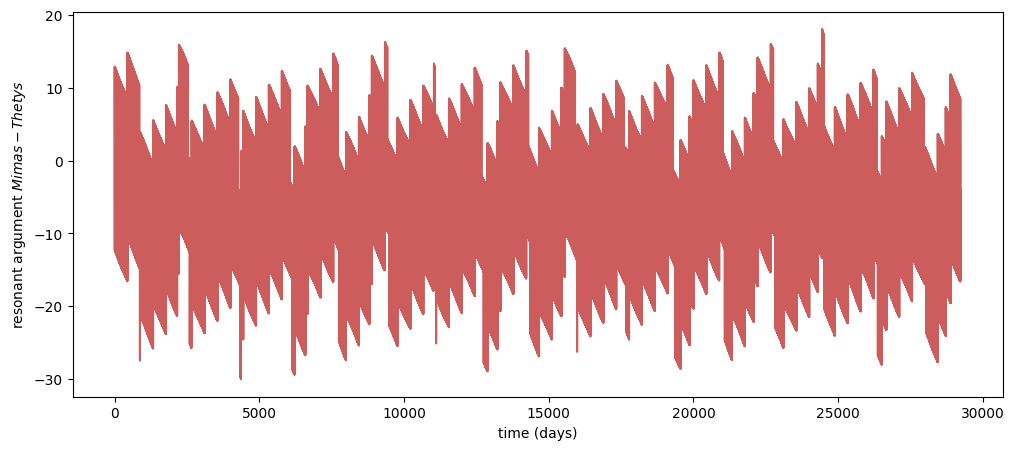

In [30]:
def zeroTo360(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

def min180To180(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return (val*180/np.pi)

# We can calculate theta, the resonant argument of the 1:2 Io-Europa orbital resonance,
# which oscillates about 0 degrees:
theta = [min180To180(2.*longitude[0][i] - 4.*longitude[1][i] + Omega[0][i] + Omega[1][i]) for i in range(Nout)]
theta2 = [2.*longitude[0][i] - 4.*longitude[1][i] + Omega[0][i] + Omega[1][i] for i in range(Nout)]

# # There is also a secular resonance argument, corresponding to the difference in the longitude of perihelions:
# # This angle oscillates around 180 degs, with a longer period component.
# theta_sec = [zeroTo360(-varpi[1][i] + varpi[0][i]) for i in range(Nout)]

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.plot(times,theta2, color="indianred")  
# ax.plot(times,theta_sec, color="royalblue") # secular resonance argument
# ax.set_xlim([0,20.*365.25])
# ax.set_xlim([10*365.25,11*365.25])
# ax.set_ylim([-180,360.])
ax.set_xlabel("time (days)")
ax.set_ylabel(r"resonant argument $Mimas-Thetys$")
# ax.plot([0,100],[180,180],'k--')
# ax.plot([0,100],[0,0],'k--')

Mean of Omega0 dot : -0.014133001073355331
Mean of Omega1 dot : -0.002838014993306112


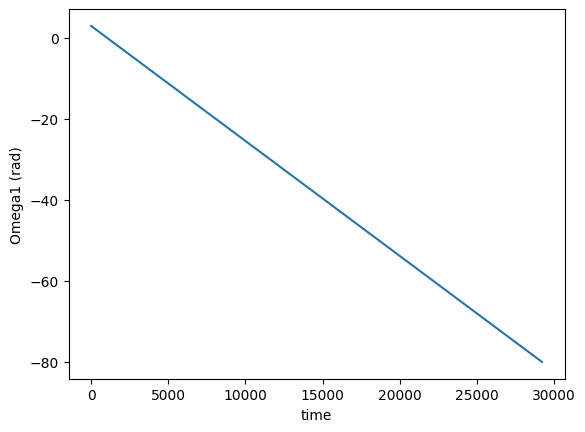

In [31]:
def mean_dOmega_dt(times, Omega):
    # Déroule la phase pour éviter les sauts 2π
    Omega_unwrapped = np.unwrap(Omega)
    # Pente moyenne globale
    return (Omega_unwrapped[-1] - Omega_unwrapped[0]) / (times[-1] - times[0])

Omega0_dot = mean_dOmega_dt(times, Omega[0])
Omega1_dot = mean_dOmega_dt(times, Omega[1])

print(f"Mean of Omega0 dot : {Omega0_dot}")
print(f"Mean of Omega1 dot : {Omega1_dot}")

plt.plot(times, np.unwrap(Omega[1]))
plt.xlabel("time")
plt.ylabel("Omega1 (rad)")
plt.show()


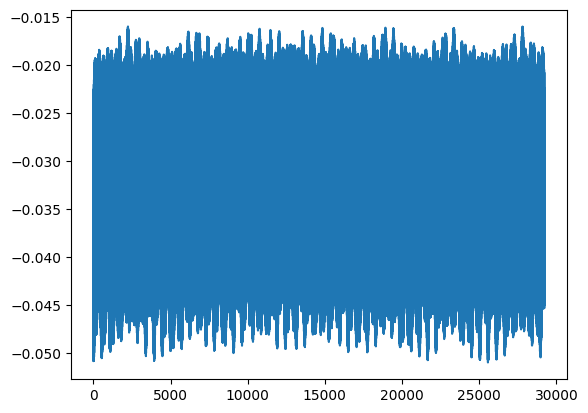

-0.03286871806898328


In [32]:
# plt.plot(times,n[1])
# plt.plot(times,n[0])
# np.save("n0", n[0])
# np.save("n1", n[1])
# np.save("Omega0", Omega[0])
# np.save("Omega1", Omega[1])
# np.save("times", times)*
OD0 = -0.014126776723940736
OD1 = -0.0028379571237117213

OD0 = -0.014133001073355331
OD1 = -0.002838014993306112
phi_dot_bienmieuxbetter = 2*n[0]-4*n[1]+OD0+OD1
plt.plot(times,phi_dot_bienmieuxbetter)
# plt.plot(times,n[1])
plt.show()

print(np.mean(phi_dot_bienmieuxbetter))

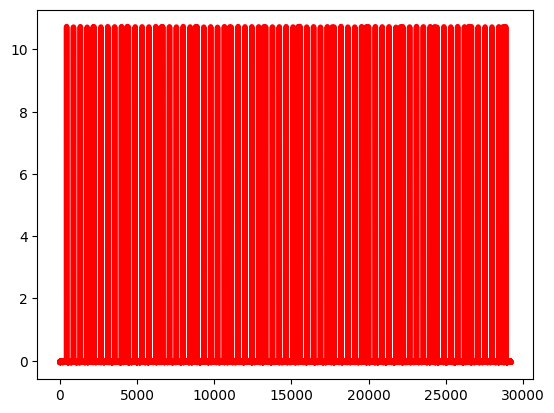

<Phi_dot> = -0.01609645267262405


In [33]:
# plt.plot(times[:-1], theta_prime[0])

dO = (np.gradient(Omega[0], times),np.gradient(Omega[1], times))

phidot = 2*n[0]-4*n[1]+dO[0]+dO[1]

plt.plot(times,phidot, lw=4, color="red")
plt.show()
print(f"<Phi_dot> = {np.mean(phidot)}")

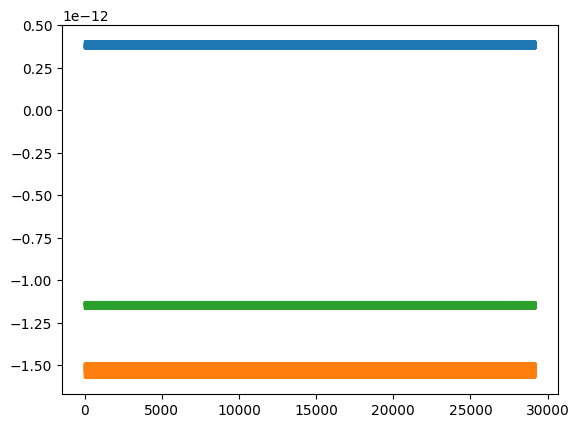

In [39]:
Ekin = 0
for k in range(len(labels)):
    vx = vit[k,0]
    vy = vit[k,1]
    vz = vit[k,2]
    m = ps[k].m
    Ekin += 0.5*m*(vx*vx+vy*vy+vz*vz)

Epot = 0
for i in range(len(ps)):
    for j in range(len(ps)):
        if i!=j:
            m1 = ps[i].m
            m2 = ps[j].m
            
            x1 = pos[i,0]
            y1 = pos[i,1]
            z1 = pos[i,2]

            x2 = pos[j,0]
            y2 = pos[j,1]
            z2 = pos[j,2]

            r = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
            Epot -= sim.G*m1*m2/r

Etot = Ekin+Epot

plt.plot(times,Ekin)
plt.plot(times,Epot)
plt.plot(times,Etot)

plt.show()